In [1]:
import torch
import torch.nn as nn
import torchdiffeq as tdf
import matplotlib.pyplot as plt
from torch import nn, optim
import numpy as np

In [20]:
device = 'cpu'
class Lorenz(nn.Module):
    def __init__(self, *args):
        super(Lorenz, self).__init__()
        self.s = args[0]
        self.r = args[1]
        self.b = args[2]

    def forward(self, t, y):
        return torch.Tensor([self.s * (y[1] - y[0]), y[0] * (self.r - y[2]) - y[1], y[0] * y[1] - self.b * y[2]])

class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 100),
            nn.Tanh(),
            nn.Linear(100,100),
            nn.Tanh(),
            nn.Linear(100,3)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)




In [21]:
true_y0 = torch.Tensor([1,2,3])
t = torch.linspace(0., 20., 1000)

lorenz_dynamic = Lorenz(10, 28, 2.667)
with torch.no_grad():
    true_y = tdf.odeint(lorenz_dynamic, true_y0, t)


def get_batch(batch_size, batch_num, total_size=len(t)):
    s = torch.from_numpy(np.random.choice(np.arange(total_size-batch_size),batch_num,replace=False))
    batch_t = t[:batch_size]
    batch_y0 = true_y[s]
    batch_y = torch.stack([true_y[s+i] for i in range(batch_size)], dim=0)
    return batch_t.to(device), batch_y0.to(device), batch_y.to(device)
# print(true_y.squeeze().T)

print(get_batch(20,100))




(tensor([0.0000, 0.0200, 0.0400, 0.0601, 0.0801, 0.1001, 0.1201, 0.1401, 0.1602,
        0.1802, 0.2002, 0.2202, 0.2402, 0.2603, 0.2803, 0.3003, 0.3203, 0.3403,
        0.3604, 0.3804]), tensor([[ -3.1813,  -3.2761,  20.5532],
        [ -2.1756,   4.0267,  29.2403],
        [-11.3872,  -0.5843,  39.8927],
        [ -4.8708,  -6.8849,  18.3725],
        [  7.9083,   0.9943,  33.5950],
        [ -5.5483,  -6.4321,  21.9638],
        [ -2.5450,  -3.4643,  17.0855],
        [ 13.8289,  15.9753,  31.7936],
        [ -9.9435,  -3.7408,  34.9923],
        [  1.7942,   0.1739,  22.8321],
        [-11.6058, -19.8251,  18.4682],
        [  1.6699,   2.2140,  16.4995],
        [  1.8021,   2.5788,  15.7226],
        [ 13.8769,  18.6813,  28.5937],
        [ 14.2062,  20.3969,  27.2834],
        [ -7.6601,  -4.3958,  29.9482],
        [ -4.6381,  -3.4096,  24.5447],
        [-12.2855, -20.4970,  20.0800],
        [ -4.9349,  -3.1940,  25.5671],
        [ -7.3865,  -9.5525,  22.1896],
        [  3.

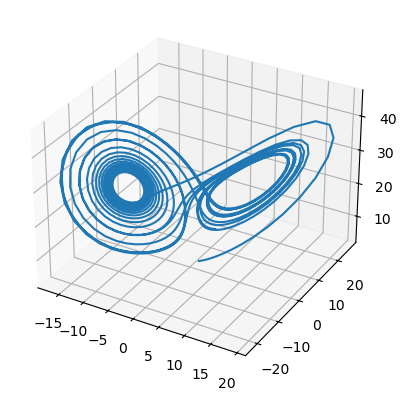

In [22]:

ax = plt.figure().add_subplot(projection='3d')
ax.plot(*true_y.squeeze().T)
plt.show()

In [23]:
func = ODEFunc().to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-2)

In [24]:
def train(max_epoch,func, lr):
    optimizer = optim.Adam(func.parameters(), lr=lr)
    for i in range(max_epoch):
        optimizer.zero_grad()
        batch_t, batch_y0, batch_y = get_batch(len(t)//20,5)
        pred_y = tdf.odeint_adjoint(func, batch_y0, batch_t)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(loss.item())


In [25]:
train(1000,func,1e-2)

6.62763786315918
6.974874973297119
5.202582836151123
7.091244697570801
5.682692527770996
3.149229049682617
3.3365790843963623
3.7832984924316406
